<a href="https://colab.research.google.com/github/Mongeese1/phyiscs-big-data/blob/master/Copy_of_Exoplanet_and_Light_curve_exercise_0.95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The GetPlanetData function searches nexsci and tess data for any exoplanet that you input into it and outputs a light curve, folded light curve as well as performing an FFI cutout and displaying the first image



Good examples are: DS Tuc A b, wasp-18 b , hat-p-24 b
The function returns errors if planet is not in tess catalogue, for example K2-22 b.
It also prints errors if planet mass or solar mass data are unavailable, however it should produce lightcurve/ffi image assuming they are available
Some exoplanets(KELT-11 b) produce a low quality FFI image, unfortunatley this is out of my control.
It also should, though untested, produce an error if the planet is not in the nexsci catalogue, however i have been unable to find an example of such.

In [0]:
#imports
#might have to !pip install astroquery or any other errors
%matplotlib inline
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.wcs import WCS
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import requests
import pandas as p
from IPython.display import display, HTML
import zipfile





# planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"

urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"
header={}


In [0]:
def GetPlanetData(name):
  #grab planet info 
  planet_name = name

  url = planeturl + "/identifiers/"

  myparams = {"name":planet_name}

  r = requests.get(url = url, params = myparams, headers = header)
  # print(r.headers.get('content-type'))

  planet_names = r.json()
  ticid = planet_names['tessID']
  tce = planet_names['tessTCE']
  planet_names


  url = planeturl + planet_name + "/properties/"

  r = requests.get(url = url, headers = header)

  planet_prop = r.json()
  #check if planet in nexsci catalogue
  try:
    planet_prop[0]
  except:
    print('Planet not in nexsci catalogue, data unavailable')
    return

  # if planet_prop[1] is None:
  #   print('Planet not in exoplanet.org catalogue, some data may be unavailable')
  # else:
  #   print("Catalog 2: " + planet_prop[1]['catalog_name'])
  # try:
  #   planet_prop[1]
  # except:
  #   print('Planet not in exoplanets.org catalogue, data unavailable')
  #   return

  print("Catalog: " + planet_prop[0]['catalog_name'])
  
  planet_prop[0].keys()
 #check mass errors
  if planet_prop[0]['Ms'] is None:
    print('Stellar Mass data unavailable')
  else:
    print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )

  if planet_prop[0]['Mp'] is None:
    print(' Planet Mass data unavailable')
  else:
    print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
    print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))
  
  
  print(planet_name, " Properties")
  
  

  url = dvurl + str(ticid) + '/tces/'
  myparams = {"tce" : tce}
  #grab exoplanet sectors
  r = requests.get(url = url, params = myparams, headers = header)
  sectorInfo = r.json()
  
  sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
  sectors
  #check whether in TESS catalogue
  try:
    sectors[0]
  except:
    print("Planet not in TESS catalogue, light curve and FFI data unavailable")
    return

  url = dvurl + str(ticid) + '/info/'
  myparams = {"tce" : tce,
              "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  tceInfo = r.json()
  tceInfo.keys()
  tceInfo['DV Data Header'].keys()

  print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
  print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

  # Get The data
  url = dvurl + str(ticid) + '/table/'
  myparams = {"tce" : tce, "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  
  tce_data = r.json()

  data = p.DataFrame.from_dict(tce_data['data'])
  data.columns

  detrend = data['LC_DETREND']
  model = data['MODEL_INIT']
  time = data['TIME']
  #plot lightcurve
  plt.figure(figsize=(14,4))
  plt.plot(time,detrend,'.',lw=0.4)
  plt.plot(time,model,'r-',lw=0.6)
  plt.xlabel('TIME (BTJD)')
  plt.ylabel('Relative Flux')
  #folded lightcurve data
  url = dvurl + str(ticid) + '/phaseplot/'
  myparams = {"tce" : tce, "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  #print folded lightcurve
  display(HTML(str(r.content.decode('utf-8'))))
  #cone search
  starName = "TIC" + str(ticid)
  radsearch = 3 / 60
  starData = Catalogs.query_object(starName, radius = radsearch, catalog = "TIC")
 
  Ra = starData[0]['ra']
  Dec = starData[0]['dec']

  # print( starData[:10]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )
  #filter for relativley bright nearby stars
  averageTmag = []
  for i in range(len(starData)):
    x = starData['Tmag'][i]
    # sus = np.sum(x, dtype=np.float64)
    averageTmag.append(x)
    # for i in range(len(starData)):
    #   average = sum(averageTmag) / len(averageTmag)
  average = sum(averageTmag) / len(averageTmag)
  brightStar = starData['Tmag'] < average
  nearbyBrightStars = list( map( lambda x,y:[x,y], starData[brightStar]['ra'], starData[brightStar]['dec'] ) )
  # print(len(nearbyBrightStars))
  #determine sectors/cameras for star
  urlStar = urlroot + "/sector"

  myparamsStar = {"ra":Ra, "dec":Dec, "radius":"0m"}

  requestDataStar = requests.get(url = urlStar, params = myparamsStar)
  sectors = requestDataStar.json()['results']
  # print(sectors)
  myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px"}

  url = urlroot + "/astrocut"

  r = requests.get(url = url, params = myparams)

  # print(r)
  # print(r.headers.get('content-type'))
  #get ffi cutouts for star
  open('astrocut.zip', 'wb').write(r.content)
  zipRef = zipfile.ZipFile('astrocut.zip','r')
  zipRef.extractall('.')
  zipRef.close()
  cutoutnames = zipRef.namelist()
  # print(cutoutnames)
  files1 = cutoutnames[0]
  # fits.info(files1)
  imageData = fits.open(files1)
  image = imageData[1].data['Flux'][0]
  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(image, origin = 'lower', cmap = plt.cm.viridis, \
  #          vmax = np.percentile(image,95), vmin = np.percentile(image,2))
  
  #produce first image of timeseries, wcs checks for star location and marks it
  wcs = WCS(imageData[2].header)
  

  fig = plt.figure(figsize = (10,10))
  fig.add_subplot(111, projection = wcs)
  plt.imshow(image, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(image,91),\
            vmin = np.percentile(image,3))
  plt.title('First image of FFI time series')

  plt.xlabel('CCD Column', fontsize = 14)
  plt.ylabel('CCD Row', fontsize = 14)
  plt.grid(axis = 'both', color = 'white', ls = 'solid')

  starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
  plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')

  # Plot nearby stars as well, which we created using our Catalog call above.
  nearbyLoc = wcs.all_world2pix(nearbyBrightStars[1:], 0)
  plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'green')
  plt.text(-5,-5,'Star which exoplanet orbits is red', bbox=dict(facecolor='red', alpha=0.5))
  plt.text(10,-5, 'Stars with above average magnitude in search area are green', bbox=dict(facecolor='green',alpha = 0.5))
  # print(requestDataStar.headers.get('content-type'))
  # print(brightStar)
  
  # print(brightStar)
  # HAT-P-30 b

# GetLightCurve("wasp-18 b")

Catalog: nexsci
Stellar Mass 1.440000 M_sun
Planet Mass 0.171000 M_Jupiter
Planet Mass Reference: Beatty et al. 2017
KELT-11 b  Properties
TIC: TIC 55092869
Planet Radius: 13.692776


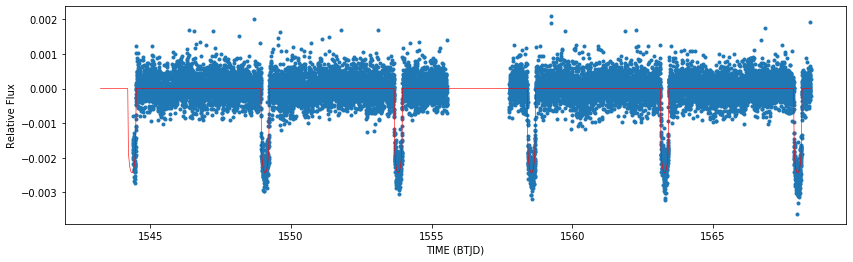

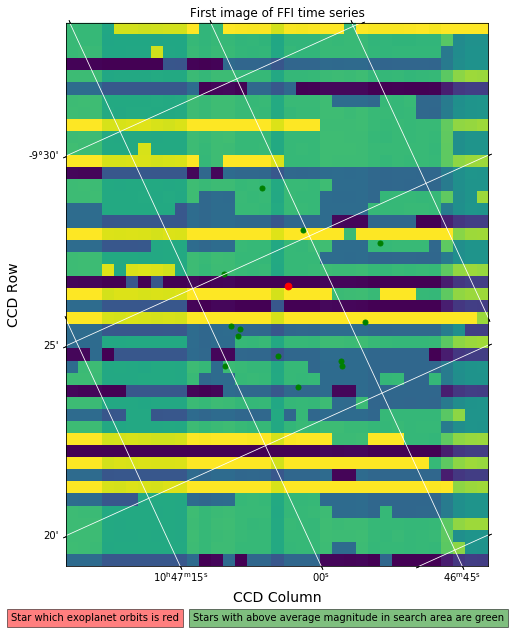

In [68]:
GetPlanetData("KELT-11 b")